In [1]:
#!pip install beautifulsoup4

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from matplotlib.dates import DateFormatter
import numpy as np

In [3]:
plt.style.use('seaborn-poster')

In [4]:
populacje = pd.read_csv("wojewodztwa_populacja.csv")

In [12]:
def get_data_single_region(url, region):
    result = requests.get(url)
    content = result.content
    soup = BeautifulSoup(content)
    #print(soup)
    
    #//blokowy hospitalizacja
    
    soup=str(soup)
    str_to_data=(soup.split("blokowy hospitalizacja")[1].split(";")[0].split("=")[1])
    #print(str_to_data)
    
    arg="Data"
    p_szpital="Hospitalizowane"
    null=0
    
    #eval(str_to_data)
    
    list_of_dicts=eval(str_to_data[1:])
    region_df=pd.DataFrame(list_of_dicts)
    region_df["województwo"]=region
    
    region_df.Data = pd.to_datetime(region_df.Data, dayfirst=True)

    
    return(region_df)

In [14]:
df=get_data_single_region("https://koronawirusunas.pl/wojewodztwo-lodzkie", "łódzkie")
print(df)

 [
	{arg: "12.03.2020",p_szpital: 43,},{arg: "13.03.2020",p_szpital: 28,},{arg: "14.03.2020",p_szpital: 57,},{arg: "16.03.2020",p_szpital: 57,},{arg: "17.03.2020",p_szpital: 32,},{arg: "19.03.2020",p_szpital: 28,},{arg: "20.03.2020",p_szpital: 15,},{arg: "21.03.2020",p_szpital: 14,},{arg: "22.03.2020",p_szpital: 23,},{arg: "23.03.2020",p_szpital: 27,},{arg: "24.03.2020",p_szpital: 51,},{arg: "26.03.2020",p_szpital: 23,},{arg: "27.03.2020",p_szpital: 34,},{arg: "28.03.2020",p_szpital: 45,},{arg: "29.03.2020",p_szpital: 40,},{arg: "30.03.2020",p_szpital: 31,},{arg: "31.03.2020",p_szpital: 35,},{arg: "01.04.2020",p_szpital: 36,},{arg: "02.04.2020",p_szpital: 32,},{arg: "03.04.2020",p_szpital: 33,},{arg: "04.04.2020",p_szpital: 37,},{arg: "05.04.2020",p_szpital: 41,},{arg: "06.04.2020",p_szpital: 43,},{arg: "07.04.2020",p_szpital: 34,},{arg: "08.04.2020",p_szpital: 35,},{arg: "09.04.2020",p_szpital: 37,},{arg: "10.04.2020",p_szpital: 40,},{arg: "11.04.2020",p_szpital: 27,},{arg: "12.04.202

In [7]:
regions_names = {
"dolnośląskie":"dolnoslaskie",
"kujawsko-pomorskie":"kujawsko-pomorskie",
"lubelskie":"lubelskie",
"lubuskie":"lubuskie",
"łódzkie":"lodzkie",
"małopolskie":"malopolskie",
"mazowieckie":"mazowieckie",
"opolskie":"opolskie",
"podkarpackie":"podkarpackie",
"podlaskie":"podlaskie",
"pomorskie":"pomorskie",
"śląskie" : "slaskie",
"świętokrzyskie":"swietokrzyskie",
"warmińsko-mazurskie":"warminsko-mazurskie",
"wielkopolskie":"wielkopolskie",
"zachodniopomorskie":"zachodniopomorskie",}


In [8]:
regional_dfs=[]
for region in regions_names:
    link = "https://koronawirusunas.pl/wojewodztwo-"+regions_names[region]
    single_df=get_data_single_region(link, region)
    regional_dfs.append(single_df)
    
all_regions = pd.concat(regional_dfs).reset_index(drop=True)


timestamp=time.strftime("%Y_%m_%d")
all_regions.to_csv("./regions_data/wojewodztwa_hospitalizacja_"+timestamp+".csv")
    

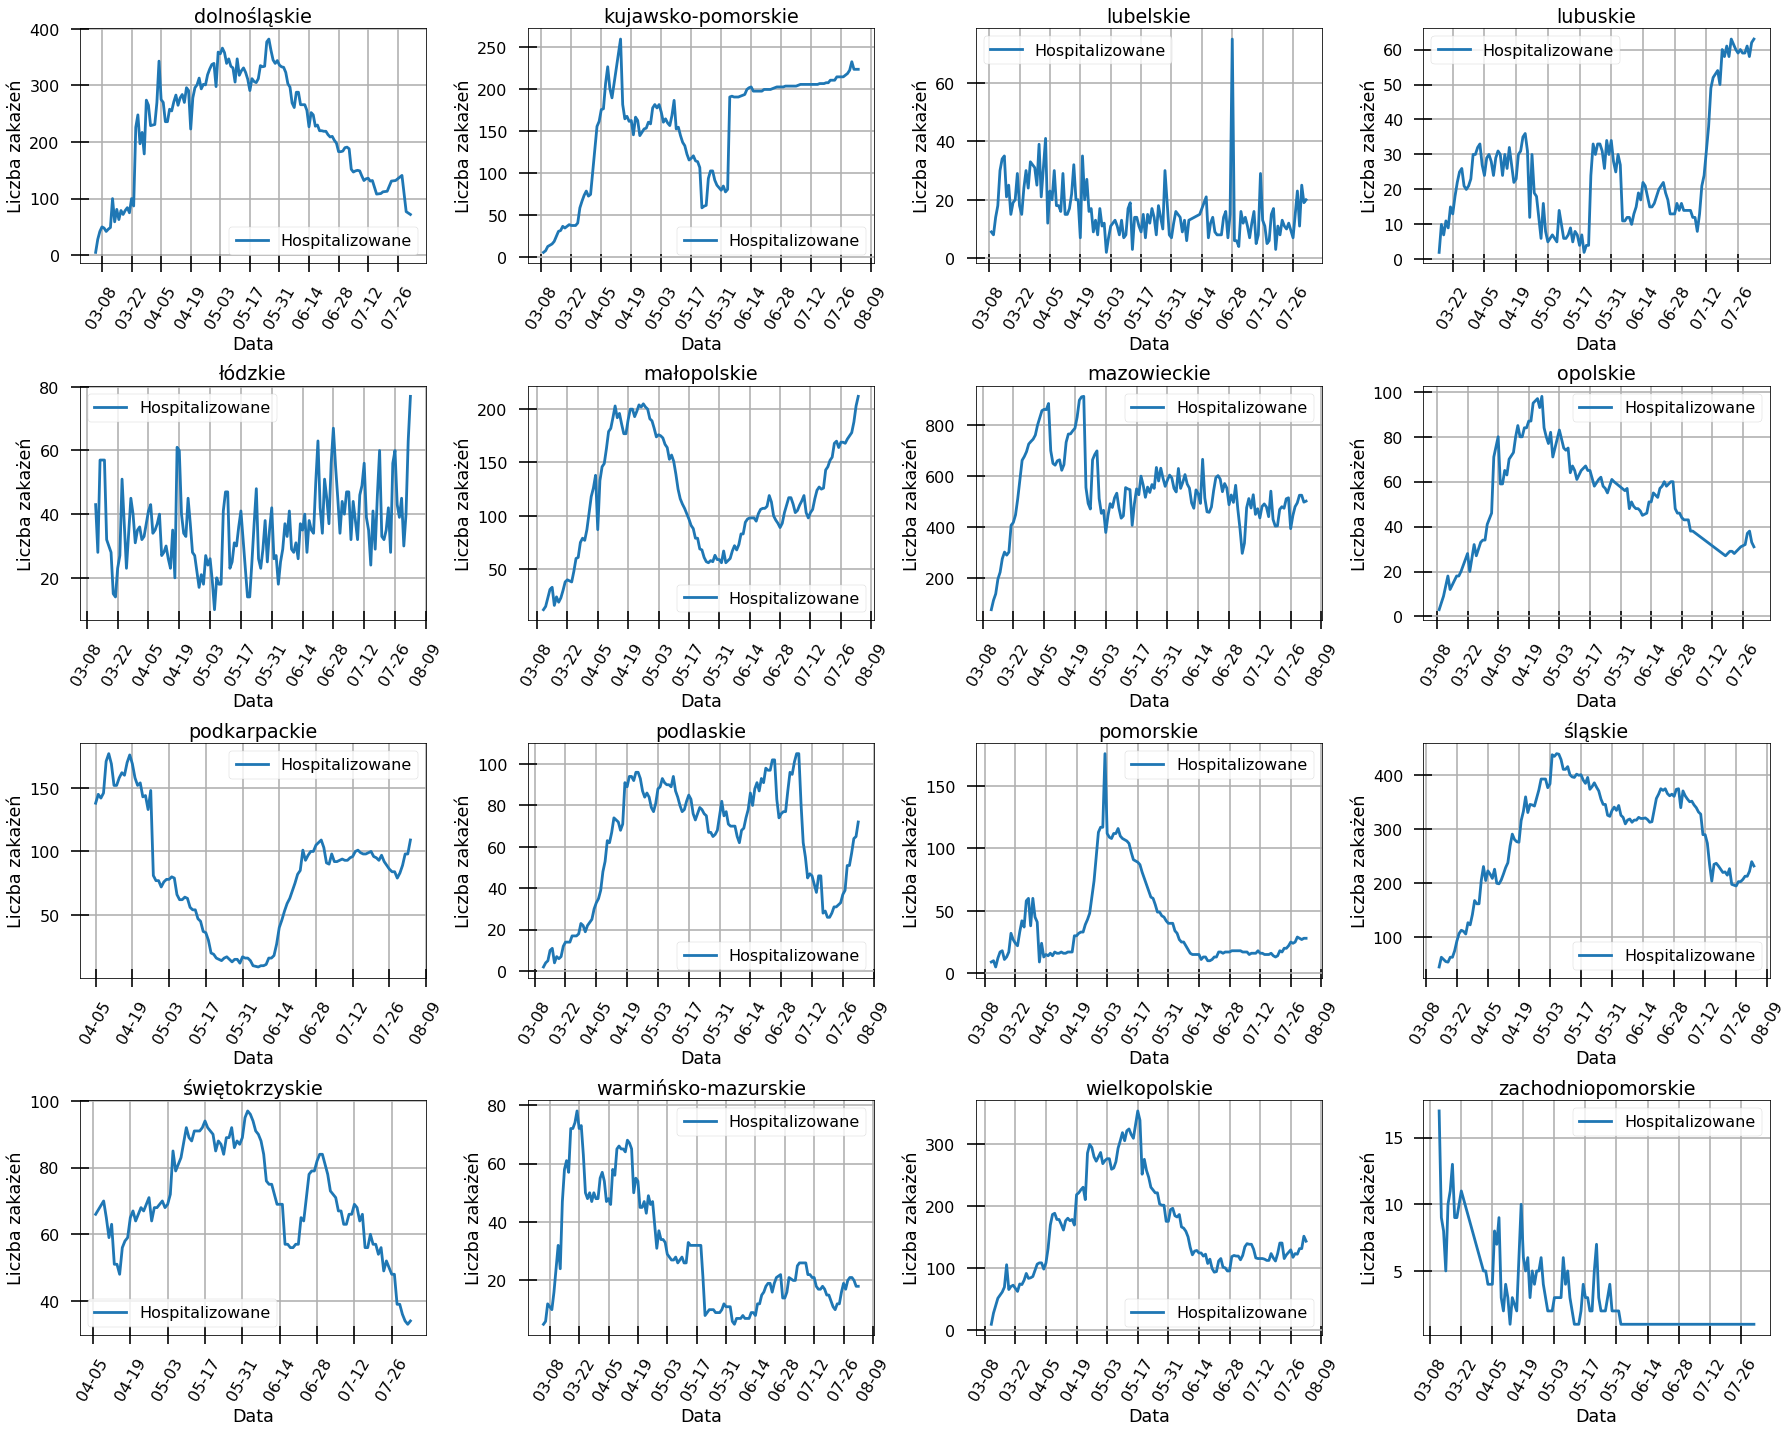

In [9]:
#all_regions['Data'] = all_regions['Data'].str.replace(r'.2020', '')


fig, axis = plt.subplots(4,4, figsize=(25, 20), sharey=False, sharex=False)
for ax, region in zip(axis.flatten(), regions_names):

    a=all_regions.loc[all_regions["województwo"]==region]

    variables = ["nowe", "zgony", "wyleczeni"]
    #a[variables] = a[variables].cumsum(axis=0)

    ax.plot(a["Data"], a["Hospitalizowane"], label="Hospitalizowane")
#    ax.plot(a["Data"], a["Potwierdzone"]-(a["zgony"]+a["wyleczeni"]), label="aktywne")
#    ax.plot(a["Data"], a["wyleczeni"], label="wyleczeni")
#    ax.plot(a["Data"], a["zgony"], label="zmarli")

    tick_spacing=14
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#    ax.set_xticks(ax.get_xticks()[::7])

#    ticks = ax.get_xticks()
#    ticks.reverse()
#    ticks=ticks[::7]
#    ticks.reverse()
#    print(ticks)
#    ax.set_xticks(ticks)
    
    
    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_tick_params(rotation=60, direction="out")
    ax.tick_params(direction='inout', length=18, colors='k')  
    
    ax.set(xlabel="Data",
    ylabel="Liczba zakażeń",
    title=region)
    
    ax.grid(True)
    ax.legend()
    
    
timestamp=time.strftime("%Y_%m_%d")
plt.tight_layout()
fig.savefig("./regions/hospitals_w_active"+timestamp+".png")
plt.show()



In [10]:
#aktywne
regional_active_pernums=[]
regional_total_pernums=[]
pernum=10000

#for region in regions:
for region in regions_names:    

    a=all_regions.loc[all_regions["województwo"]==region]["aktywne"]
    b=all_regions.loc[all_regions["województwo"]==region]["Potwierdzone"]

    active_per_pernum=((a.values / populacje[populacje["region"] == region].population.values[0])*pernum)[-1]
    total_per_pernum=((b.values / populacje[populacje["region"] == region].population.values[0])*pernum)[-1]
    

    regional_active_pernums.append(active_per_pernum)
    regional_total_pernums.append(total_per_pernum)



    
#for region in regions_names:
#    per_pernum=((a.values / populacje[populacje["region"] == region].population.values[0])*pernum)[-1]
#    print(np.round(per_pernum,2))

nums_regions = sorted(zip(regional_active_pernums, regional_total_pernums, regions_names), reverse=True)
print(nums_regions)


print("")    


for act_num, tot_num, reg in nums_regions:
    print(reg)



print("")        
print("active")    
print("")    

    
for act_num, tot_num, reg in nums_regions:
    print(np.round(act_num,2))

print("")       
print("total")
print("")    

for act_num, tot_num, reg in nums_regions:
    print(np.round(tot_num,2))

KeyError: 'aktywne'